# **Simulation of evolution by natural selection**

## **Acknowledgement**

The following work is greatly derived from the [work](https://www.youtube.com/watch?v=N3tRFayqVtk&t=821s) of [David Randall Miller](https://www.youtube.com/@davidrandallmiller). I had to put the link to his YouTube channel for want of a better profile. I was greatly inspired by his video on programming creatures with genes and watching them evolve and wanted to try my hand at the same task. It was my introduction to genetic algorithm, therefore, I used some of the resources provided in his video as a starting point for my project along with my own modifications and solutions. The following ideas have been borrowed from his work:


*   The goal of the project. i.e., evolving organisms to migrate to a safe zone.
*   Permissible neural network connections.
*   Representing gene sequences in hexdecimal and the process of interpreting it as neural network connections.



## **Abstract**

This project is a simple simulation of evolution by natural selection. Natural selection is the process by which some real world organisms learn from their surroundings better than others and over several generations become capable in maintaining a stable population while the others go extinct. Just like in a natural scenario, we start off with a number of different species (represented by dots) in a pre-defined 2D space with their own gene sequences which determine their brain connections and functions. Each individual has a sparse neural network brain with some pre-defined neurons, but the connections among these neurons are established according to their genes. There is a "safe zone" in the 2D space where these dots (or organisms) have to migrate to in order to reproduce. Their task is to learn how to reach the safe zone by the end of their lifetime starting at any random location. We find that some of the organisms learn to reach the safe zone fairly well and are able to produce the next generation while others simply get eliminated.

## **Introduction**

The algorithm used in this project is known as ***Genetic Algorithm***, which is a search and optimisation technique. It was in fact inspired by principles of genetics and natural selection. The following is a simple explanation of how it works:


1.   A random starting population is created as potential solutions to a given problem. The size of the population large, small or average depending on the complexity of the problem.
2.   The performance of each individual from 1. is evaluated against the problem and the results are recorded.
3.   The individuals that performed well in 2. are chosen to reproduce the next batch of individuals, i.e., the next generation while the non performers are discarded.
4.   The reproduction is carried out by techniques such as ***cross-over*** and ***mutation***. Cross-over refers to exchange of sections of genes between two parents to form the offspring's gene sequence. Mutation refers to random changes introduced to the gene sequence resulting from the cross-over.
5.   The offsprings from 4. make the next generation of individuals and the process continues until a stopping criteria is reached. This is often set according to the achievement of a satisfactory solution.


With each new generation, the algorithm generates an increasingly better performing population of individuals as the reproductions produce offsprings with the most efficient and desirable qualities for solving the problem. Over multiple generations, the population will be much more evolved than the first generation population at tackling the problem.

#### Applications
This algorithm is very efficient in practice. It can explore a vast state space and can be applied to various disciplines for obtaining the best or the most optimal solutions. For example, forecasting and scheduling, path optimisation, detecting maxima and minima of functions such as that of profit and cost, tuning parameters of existing data models and so on.

On top of it, it has several advantages over other optimisation algorithms such as it can explore a wide array of candidate solutions while still converging towards a required result. It doesn't depend on gradients and therefore can work with non-differentiable functions, it is robust to noise and uncertainty and so on.

Now let's begin with the project. As always, the first step is importing all the necessary libraries. As a side note, I would like to state that here onwards, I have referred to each individual entity of a population as an *organism* in both the explanation and in the code. Although, one might say it is a misnomer as there is nothing organic about these entities, but as they are sensing their surroundings and performing some actions that mimic real organs and given that the project is about evolution, I thought it would make sense to call them organisms.

In [ ]:
# Import the necessary libraries

import numpy as np
import random
import math
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import textwrap
import warnings
warnings.filterwarnings('ignore')

random.seed(9)

I have defined a sigmoid function for activation of neurons. I have tested with two kinds of activation, sigmoid and tanh. Finally I settled with using tanh activation for the neurons.

In [ ]:
# a sigmoid function is defined for neuron activation

def sigmoid(array):
    sigmoid_array = 1 / (1 + np.exp(-array))
    return sigmoid_array

## **Neural Network class**

A brief description of the neural network class and the class functions.

*   There are some initialisation objects that all organisms of the population will have. Such as, starting position, current position (that changes as the organism moves), the sensory receptions (input vector), the gene sequence in hexadecimal and binary, etc.

*   A function *make_gene_sequence* that randomly generates a gene sequence for each organism of the starting population only. It is therefore used only once in a complete simulation. The gene sequences for subsequent generations are obtained by cross over between parents. The structure of the gene is as follows:


>  1.   A single gene sequence is comprised of a number of genomes given by its length. For example, a gene sequence of length 3 may look like ['1f4de234', '105ca2eb', '62dac7ed'] which has 3 genomes.
>  2.   Each genome is comprised of 8 hexadecimal numbers.
>  3.   A genome also represents a single connection in the neural network. That means, an organism with the above gene sequence will have 3 individual connections in its neural network.


*   The function *convert_gene_binary* converts each of the genomes in the whole gene from hexadecimal to a 32 bit binary number and stores it similarly in a list. For example, the first genome in the above gene '1f4de234' becomes 0001 1111 0100 1101 1110 0010 0011 0100 and so on.


*   The function *make_connections* uses the binary encoding of the gene sequence of an organism to establish its specific neural network connections. As mentioned before, the genome of 8 hexadecimal characters represent a single connection. In binary, the 32 bits represent the same connection. Before proceeding to how the connections are determined, it is important to note the structure and the types of connections allowed in the neural network brains of the organisms.

>   There are only 3 layers. An input layer with 24 neurons, represnting the 24 total input values possible. A hidden layer which can have any number of neurons as per choice and an output layer with 14 neurons for each of the 14 outputs possible in this project. Connections can be made between input-output, input-hidden, hidden-hidden (as in an RNN where a hidden layer feeds output to itself) and hidden-output.

>   To determine the connections, the 32 bit binary form of the genome is split into 5 parts. If each of them are indexed with numbers from 1 to 32 then it goes as follows:
>*    index 1: The source. 0 means an input neuron, 1 means hidden neuron. In our example it is 0 and so it is a connection from an input neuron.
>*    indices 2-8: Source id. Convert the 7 bit number to an unsigned integer then take modulus (%) of the total number of source neurons. In the example it is 0011111 which converted to unsigned int is 31. The total number of source neurons in this case is 24. Therefore the source id 31%24 = 7 meaning it is the 7th input neuron.
>*    index 9: Sink. 0 for output, 1 for hidden. In the example, it is 0 meanining it is an output neuron.
>*    indices 10-16: Sink id. Similar to determining source id. In the example it is 1001101, converted to unsigned int gives 77 and the number of output neurons is 14. Therefore the sink id is 77%14 = 7, meaning it is the 7th output neuron.
>*    indices 17-32: Connection weight. Convert the remaining bits to a signed integer 1110001000110100 = -25140. But neural network connection weights are normally much lower than these values so the resulting value has to be divided by a constant like 10000.

>   Therefore, in conclusion, the example genome represents a connection between input neuron 7 and output neuron 7 with a connection weight of -2.5.


*   The *forward_pass* function makes a forward pass through the neural network and generates a response or motor action based on the current position and other sensory receptions of an organism.

In [ ]:
# a neural network class is defined to assign neural networks (NN) and properties of similar type to each organism

class neural_network():

  # initialise each organism with some properties

  def __init__(self, coordinates):
    self.position = random.choice(coordinates)    # current position of organism
    coordinates.remove(self.position)             # position assigned to this organism removed from pool to avoid duplicate starting positions
    self.starting_pos = self.position             # starting position, required to calculate displacement at the end of lifetime
    
    self.input_vector = []                        # NN input vector
    self.gene_hex = []                            # gene sequence, i.e. NN connections in hexadecimal
    self.gene_bin = []                            # NN connections in binary
    self.last_x_mov = 0                           # organism's last motion along x axis
    self.last_y_mov = 0                           # organism's last motion along y axis
    self.displacement = 0                         # organism's displacement in space at the end of its lifetime
    self.xsteps = 0                               # net steps along x axis (right +, left -)
    self.ysteps = 0                               # net steps along y axis (up +, down -)


  
  
  # create a randomised gene sequence for generation 1

  def make_gene_sequence(self, gene_hex, gene_length):
    self.gene_hex = []
    for _ in range(gene_length):
      random_genome = random.choices([str(x) for x in list(range(10))]+['a', 'b', 'c', 'd', 'e', 'f'], k=8)
      self.gene_hex.append(''.join(random_genome))

  
  
  
  # convert hexadecimal gene sequence to binary

  def convert_gene_binary(self, gene_hex, gene_bin):
    self.gene_bin = []
    for gene in self.gene_hex:
      bin_genome = []
      for g in gene:
        seg = bin(int(g, 16))[2:].zfill(4)
        bin_genome+=seg
      self.gene_bin.append(''.join(bin_genome))



  
  # set sparse neural network connections and weights using the gene sequence in binary format from above

  def make_connections(self, gene_bin):
    n_input = 25        # 25 neuron input layer, equal to number of sensory functions of each organism
    n_hidden = 2       # 2 neuron single hidden layer
    n_output = 25       # 15 neuron output layer, equal to number of motor functions of each organism
    div = 9000
    
    
    # first define n-dim arrays representing different layers with no connections and weights

    self.input_hidden_connection = np.zeros((n_input, n_hidden))
    self.hidden_output_connection = np.zeros((n_hidden, n_output))
    self.hidden_hidden_connection = np.zeros((n_hidden, n_hidden))
    self.input_output_connection = np.zeros((n_input, n_output))

    self.input_hidden_weight = np.zeros((n_input, n_hidden))
    self.hidden_output_weight = np.zeros((n_hidden, n_output))
    self.hidden_hidden_weight = np.zeros((n_hidden, n_hidden))
    self.input_output_weight = np.zeros((n_input, n_output))

    self.hidden_state = np.zeros((1, n_hidden))       # a hidden state has been initialised to mimic rentention of information as in an RNN


    
    
    # set connections and weights on the blank NN

    for connection in self.gene_bin:
      source = int(connection[0])
      source_id = ''.join(connection[1:8])
      sink = int(connection[8])
      sink_id = ''.join(connection[9:16])
      connection_weight = ''.join(connection[16:])

      if source==0 and sink==1:
        source_id = int(source_id, 2)%n_input
        sink_id = int(sink_id, 2)%n_hidden
        self.input_hidden_connection[source_id][sink_id] = 1
        self.input_hidden_weight[source_id][sink_id] = (int(connection_weight, 2) - 2**16 if int(connection_weight[0]) else int(connection_weight, 2))/div

      if source==1 and sink==0:
        source_id = int(source_id, 2)%n_hidden
        sink_id = int(sink_id, 2)%n_output
        self.hidden_output_connection[source_id][sink_id] = 1
        self.hidden_output_weight[source_id][sink_id] = (int(connection_weight, 2) - 2**16 if int(connection_weight[0]) else int(connection_weight, 2))/div

      if source==0 and sink==0:
        source_id = int(source_id, 2)%n_input
        sink_id = int(sink_id, 2)%n_output
        self.input_output_connection[source_id][sink_id] = 1
        self.input_output_weight[source_id][sink_id] = (int(connection_weight, 2) - 2**16 if int(connection_weight[0]) else int(connection_weight, 2))/div

      if source==1 and sink==1:
        source_id = int(source_id, 2)%n_hidden
        sink_id = int(sink_id, 2)%n_hidden
        self.hidden_hidden_connection[source_id][sink_id] = 1
        self.hidden_hidden_weight[source_id][sink_id] = (int(connection_weight, 2) - 2**16 if int(connection_weight[0]) else int(connection_weight, 2))/div
  
  


  
  # define forward pass to obtain output for the dynamically created nn
  # NOTE: Here I have finally used a tanh activation so the sigmoid activation lines have been commented

  def forward_pass(self):  
    self.hidden_layer_output = np.tanh(np.dot(np.transpose(self.input_vector), self.input_hidden_weight) + self.hidden_state)
    # self.hidden_layer_output = sigmoid(np.dot(np.transpose(self.input_vector), self.input_hidden_weight) + self.hidden_state)
    self.hidden_state = np.dot(self.hidden_layer_output, self.hidden_hidden_weight) * 0.05
    self.output_layer_output = np.tanh(np.dot(np.transpose(self.input_vector), self.input_output_weight) + np.dot(self.hidden_layer_output, self.hidden_output_weight))
    # self.output_layer_output = sigmoid(np.dot(np.transpose(self.input_vector), self.input_output_weight) + np.dot(self.hidden_layer_output, self.hidden_output_weight))


    # for tanh activation function
    softmax_outputs = np.exp(self.output_layer_output) / np.sum(np.exp(self.output_layer_output))   # softmax conversion of tanh outputs
    self.reaction = np.argmax(softmax_outputs[0])


    # # for sigmoid activation function
    # output_sum = sum(self.output_layer_output[0])
    # normalised_output = [x/output_sum for x in self.output_layer_output[0]]
    # self.reaction = np.argmax(normalised_output)
    

## **Input sensory functions**

The various sensory inputs available to an organism.

In [ ]:
# for measuring distance from the 4 boundaries

def dist_e(boundary, position):
  return abs(boundary-position[0])

def dist_w(boundary, position):
  return abs(-boundary-position[0])

def dist_n(boundary, position):
  return abs(boundary-position[1])

def dist_s(boundary, position):
  return abs(-boundary-position[1])
  

In [ ]:
# for measuring distance from the 4 corners

def dist_ne(boundary, position):
  dist_x = boundary-position[0]
  dist_y = boundary-position[1]
  dist_sq = dist_x**2 + dist_y**2
  return dist_sq**0.5

def dist_nw(boundary, position):
  dist_x = -boundary-position[0]
  dist_y = boundary-position[1]
  dist_sq = dist_x**2 + dist_y**2
  return dist_sq**0.5

def dist_se(boundary, position):
  dist_x = boundary-position[0]
  dist_y = -boundary-position[1]
  dist_sq = dist_x**2 + dist_y**2
  return dist_sq**0.5

def dist_sw(boundary, position):
  dist_x = -boundary-position[0]
  dist_y = -boundary-position[1]
  dist_sq = dist_x**2 + dist_y**2
  return dist_sq**0.5
  

In [ ]:
# for measuring distance from the centre

def dist_ctr(position):
  dist_sq = position[0]**2+position[1]**2
  return dist_sq**0.5
  

In [ ]:
# for checking if the adjacent grid point in all 8 directions is occupied

def e_occupied(position, org_list, restricted):
  temp = 0
  east_pos = [position[0]+1, position[1]]
  if (east_pos in [k.position for k in org_list]) or (east_pos in restricted):
    temp = 1

  return temp

def w_occupied(position, org_list, restricted):
  temp = 0
  west_pos = [position[0]-1, position[1]]
  if (west_pos in [k.position for k in org_list]) or (west_pos in restricted):
    temp = 1
    
  return temp

def n_occupied(position, org_list, restricted):
  temp = 0
  north_pos = [position[0], position[1]+1]
  if (north_pos in [k.position for k in org_list]) or (north_pos in restricted):
    temp = 1
    
  return temp

def s_occupied(position, org_list, restricted):
  temp = 0
  south_pos = [position[0], position[1]-1]
  if (south_pos in [k.position for k in org_list]) or (south_pos in restricted):
    temp = 1
    
  return temp

def ne_occupied(position, org_list, restricted):
  temp = 0
  ne_pos = [position[0]+1, position[1]+1]
  if (ne_pos in [k.position for k in org_list]) or (ne_pos in restricted):
    temp = 1
    
  return temp

def nw_occupied(position, org_list, restricted):
  temp = 0
  nw_pos = [position[0]-1, position[1]+1]
  if (nw_pos in [k.position for k in org_list]) or (nw_pos in restricted):
    temp = 1
    
  return temp

def se_occupied(position, org_list, restricted):
  temp = 0
  se_pos = [position[0]+1, position[1]-1]
  if (se_pos in [k.position for k in org_list]) or (se_pos in restricted):
    temp = 1
    
  return temp

def sw_occupied(position, org_list, restricted):
  temp = 0
  sw_pos = [position[0]-1, position[1]-1]
  if (sw_pos in [k.position for k in org_list]) or (sw_pos in restricted):
    temp = 1
    
  return temp
  

A brief description of what I mean by "4 regions" below. Every organism's location on the 2D surface can be considered as the point of intersection of two lines. One parallel to the x axis and the other to y axis. If you can imagine this lines to be drawn on the surface, they would divide the surface in 4 rectangles. These are the 4 regions, and the number of organisms in each of these 4 regions divided by their area gives the population density of the region.

In [ ]:
# for calculating the population density in the 4 surrounding regions

def pop_dense_ne(org_list, position, boundary):
  ctr = 0
  x_dist = boundary-position[0]
  y_dist = boundary-position[1]
  area = x_dist*y_dist
  for org in org_list:
    if org.position[0]>position[0] and org.position[1]>position[1]:
      ctr+=1
  
  if area!=0:
    density = ctr/area
  elif area==0:
    density = 0
  return density

def pop_dense_nw(org_list, position, boundary):
  ctr = 0
  x_dist = abs(-boundary-position[0])
  y_dist = boundary-position[1]
  area = x_dist*y_dist
  for org in org_list:
    if org.position[0]<position[0] and org.position[1]>position[1]:
      ctr+=1

  if area!=0:
    density = ctr/area
  elif area==0:
    density = 0
  return density

def pop_dense_se(org_list, position, boundary):
  ctr = 0
  x_dist = boundary-position[0]
  y_dist = abs(-boundary-position[1])
  area = x_dist*y_dist
  for org in org_list:
    if org.position[0]>position[0] and org.position[1]<position[1]:
      ctr+=1
  
  if area!=0:
    density = ctr/area
  elif area==0:
    density = 0
  return density

def pop_dense_sw(org_list, position, boundary):
  ctr = 0
  x_dist = abs(-boundary-position[0])
  y_dist = abs(-boundary-position[1])
  area = x_dist*y_dist
  for org in org_list:
    if org.position[0]<position[0] and org.position[1]<position[1]:
      ctr+=1
  
  if area!=0:
    density = ctr/area
  elif area==0:
    density = 0
  return density

In [ ]:
# for calculating the population density in the next 7 grid points in the forward direction

def pop_dense_forward(org_list, agent, boundary):
  forward_path = []
  x = agent.position[0]
  y = agent.position[1]
  for i in range(7):
    x+=agent.last_x_mov
    y+=agent.last_y_mov
    forward_path.append([x, y])

  forward_path = [k for k in forward_path if ((k[0]>-boundary and k[0]<boundary) and (k[1]>-boundary and k[1]<boundary))]

  ctr = 0
  for org in org_list:
    if org.position in forward_path:
      ctr+=1

  if len(forward_path)!=0:
    density = ctr/len(forward_path)
  else:
    density = 0

  return density


In [ ]:
# for detecting the nearest boundary

def nearest_boundary(boundary, position):
  distance_list = [dist_e(boundary, position), dist_w(boundary, position), dist_n(boundary, position), dist_s(boundary, position)]
  distance_list = np.array(distance_list)

  return np.argmax(distance_list)+1


## **Output motor functions**

All the motor functions available. All movements are limited to a maximum of 1 step per iteration

In [ ]:
# for moving in any of the 8 directions

def move_e(boundary, position):
  new_position = []
  if position[0]<boundary-1:
    new_position.append(position[0]+1)
    new_position.append(position[1])
    return new_position
  else:
    return position

def move_w(boundary, position):
  new_position = []
  if position[0]>-boundary+1:
    new_position.append(position[0]-1)
    new_position.append(position[1])
    return new_position
  else:
    return position

def move_n(boundary, position):
  new_position = []
  if position[1]<boundary-1:
    new_position.append(position[0])
    new_position.append(position[1]+1)
    return new_position
  else:
    return position

def move_s(boundary, position):
  new_position = []
  if position[1]>-boundary+1:
    new_position.append(position[0])
    new_position.append(position[1]-1)
    return new_position
  else:
    return position

def move_ne(boundary, position):
  new_position = []
  if position[0]<boundary-1 and position[1]<boundary-1:
    new_position.append(position[0]+1)
    new_position.append(position[1]+1)
    return new_position
  else:
    return position

def move_nw(boundary, position):
  new_position = []
  if position[0]>-boundary+1 and position[1]<boundary-1:
    new_position.append(position[0]-1)
    new_position.append(position[1]+1)
    return new_position
  else:
    return position

def move_se(boundary, position):
  new_position = []
  if position[0]<boundary-1 and position[1]>-boundary+1:
    new_position.append(position[0]+1)
    new_position.append(position[1]-1)
    return new_position
  else:
    return position

def move_sw(boundary, position):
  new_position = []
  if position[0]>-boundary+1 and position[1]>-boundary+1:
    new_position.append(position[0]-1)
    new_position.append(position[1]-1)
    return new_position
  else:
    return position
    

In [ ]:
# for moving towards the centre of the surface

def move_ctr(boundary, position):
  if position[0]==0 and position[1]==0:
    return position
  
  else:
    new_position = []
    if abs(position[0])>abs(position[1]):
      if position[0]>0:
        new_position.append(position[0]-1)
        new_position.append(position[1])
      if position[0]<0:
        new_position.append(position[0]+1)
        new_position.append(position[1])

    if abs(position[0])<abs(position[1]):
      if position[1]>0:
        new_position.append(position[0])
        new_position.append(position[1]-1)
      if position[1]<0:
        new_position.append(position[0])
        new_position.append(position[1]+1)

    if abs(position[0])==abs(position[1]):
      if position[0]>0 and position[1]>0:
        new_position.append(position[0]-1)
        new_position.append(position[1]-1)
      if position[0]>0 and position[1]<0:
        new_position.append(position[0]-1)
        new_position.append(position[1]+1)
      if position[0]<0 and position[1]>0:
        new_position.append(position[0]+1)
        new_position.append(position[1]-1)
      if position[0]<0 and position[1]<0:
        new_position.append(position[0]+1)
        new_position.append(position[1]+1)

    return new_position

In [ ]:
# for no movement

def move_none(boundary, position):
  return position
  

Having the information of an organism's last movement in x and y directions, we can easily get the next coordinates for moving forward and backward. For a forward motion, we just add the last movement values and for backwards, we subtract these values from the current position.

In [ ]:
# for moving forward and backward with respect to direction of movement in the previous step

def move_forward(boundary, agent):
  new_position = []
  new_position.append(agent.position[0]+agent.last_x_mov)
  new_position.append(agent.position[1]+agent.last_y_mov)

  if (new_position[0]>-boundary and new_position[0]<boundary) and (new_position[1]>-boundary and new_position[1]<boundary):
    return new_position
  else:
    return agent.position

def move_backward(boundary, agent):
  new_position = []
  new_position.append(agent.position[0]-agent.last_x_mov)
  new_position.append(agent.position[1]-agent.last_y_mov)

  if (new_position[0]>-boundary and new_position[0]<boundary) and (new_position[1]>-boundary and new_position[1]<boundary):
    return new_position
  else:
    return agent.position

Until now all the movements were being measured and calculated from an external observer's frame of reference, eg, someone who is looking at the 2D surface from the top like us. But for a right - left motion, we have to take into account every organism's direction of forward motion and determine what **their** right or left turn will be. Although it can be done from an external frame of reference, but we have to take every possible direction of forward motion into account. It's very straightforward as there are only 8 possible directions but we will use some geometry to do this dynamically, essentially from the organisms' frame of reference.

Let an organism's current position be the starting point and the position in its forward motion be the end point for a line segment. Let us treat the movement from the current position to the forward position as a vector and call it v1. Having the coordinates at 2 points, we can determine the slope (m) of the line segment. We know that a right or left turn will be on a line perpendicular to this line segment. The slope of this perpendicular line will be -1/m. At the same time rotating vector v1 with the axis at the starting point by 90 degrees clockwise (for right turn) and anticlockwise (for left) will fall on the perpendicular line. Knowing its slope, we can easily find the equation of the perpendicular line. Calculating the distance (d) between the starting point and the forward motion point, we can find 2 points (p1 and p2) on the perpendicular line with the same distance on both sides of the starting point which are our left and right turn coordinates. Next, considering a circle with radius d and centre at the starting point, we can calculate the angle vector v1 covers to reach each point p1 and p2. Considering an anticlockwise motion, the point reached by v1 by a 90 degree rotation is the left turn coordinate while the one with 270 degree rotation is the right turn coordinate.

In [ ]:
# for turning right and left with respect to direction of movement in previous step

def right_left_turn(center, forward):
  points = []

  if (forward[0]-center[0])!=0 and ((forward[1]-center[1])/(forward[0]-center[0]))!=0:
    slope1 = (forward[1]-center[1])/(forward[0]-center[0])
    slope2 = int(-1/slope1)
    dist = round(((forward[0]-center[0])**2 + (forward[1]-center[1])**2)**0.5)

    for i in range(-10,11):
      for j in range(-10,11):
        ndist = round(((i-center[0])**2 + (j-center[1])**2)**0.5)
        eqval = j-center[1] - (slope2*(i-center[0]))

        if ndist==dist and eqval==0:
          points.append([i,j])

  elif (forward[0]-center[0])==0:
    dist = abs(round(forward[1]-center[1]))
    
    for i in range(-10,11):
      ndist = abs(round(i-center[0]))
      if ndist==dist:
        points.append([i, center[1]])

  elif ((forward[1]-center[1])/(forward[0]-center[0]))==0:
    dist = abs(round(forward[0]-center[0]))
    
    for i in range(-10,11):
      ndist = abs(round(i-center[1]))
      if ndist==dist:
        points.append([center[0], i])

  turns = {}

  for point in points:
    angle1 = math.atan2(forward[1] - center[1], forward[0] - center[0])
    angle2 = math.atan2(point[1] - center[1], point[0] - center[0])

    theta = angle2 - angle1

    if theta < 0:
      theta += 2 * math.pi

    angle = math.degrees(theta)
    if angle==270:
      turns['right'] = point
    if angle==90:
      turns['left'] = point

  return turns



def turn_right(boundary, agent):
  new_position = []
  center = agent.position
  forward = move_forward(boundary, agent)
  if forward!=center:
    turning_points = right_left_turn(center, forward)
    try:
      new_position = turning_points['right']
    except:
      pass

  if len(new_position) and (new_position[0]>-boundary and new_position[0]<boundary) and (new_position[1]>-boundary and new_position[1]<boundary):
    return new_position
  else:
    return agent.position
    
  
def turn_left(boundary, agent):
  new_position = []
  center = agent.position
  forward = move_forward(boundary, agent)
  if forward!=center:
    turning_points = right_left_turn(center, forward)
    try:
      new_position = turning_points['left']
    except:
      pass

  if len(new_position) and (new_position[0]>-boundary and new_position[0]<boundary) and (new_position[1]>-boundary and new_position[1]<boundary):
    return new_position
  else:
    return agent.position


In [ ]:
# for moving in any random direction

def move_rnd(boundary, agent):
  new_position = []
  way = random.choice([1,0])
  if way==1:
    new_position = random.choice([move_e, move_w, move_n, move_s, move_ne, move_nw, move_se, move_sw])(boundary, agent.position)
  if way==0:
    new_position = random.choice([move_forward, move_backward, turn_right, turn_left])(boundary, agent)

  return new_position

In [ ]:
# dictionaries of the output motor functions with possible output index of NN as keys
# 2 separate dictionaries as all functions in dict 1 take a certain set of parameters whereas dict 2 takes a different set of parameters

movement_dict1 = {0: move_e, 1: move_w, 2: move_n, 3: move_s, 4: move_ne, 5: move_nw, 6: move_se, 7: move_sw, 8: move_none, 9: move_ctr}
movement_dict2 = {10: move_forward, 11: move_backward, 12: turn_right, 13: turn_left, 14: move_rnd}

## **Selection function**

The selection function is very simple. It checks which organisms made it to the safe zone by the end of their lifetime using its last position object and selects them for producing the next generation of population 

In [ ]:
# to identify the organisms/agents that were able to make it to the safe-zone

def selection_function(organisms, limit):
  pool = []
  for org in organisms:
    if abs(org.position[0])>limit:
      pool.append(org)
  return pool


In [ ]:
# calculates jaccard similarity (unused in this project but I let it remain)

# def jaccard_similarity(p1, p2):
#   seq1 = ''.join(p1)
#   seq2 = ''.join(p2)
  
#   kmer1 = []
#   kmer2 = []

#   for i in range(len(seq1)-2):
#     kmer1.append(seq1[i]+seq1[i+1]+seq1[i+2])
#     kmer2.append(seq2[i]+seq2[i+1]+seq2[i+2])

#   intersection = set(kmer1) & set(kmer2)
#   union = set(kmer1) | set(kmer2)
#   similarity = len(intersection)/len(union)

#   return similarity


## **Standard deviation calculator**

In [ ]:
# calculates the standard deviation of an array by the Welford algorithm 

def running_stats(samples):
  m = 0
  S = 0
  for i in range(len(samples)):
    x = samples[i]
    old_m = m
    m = m + (x-m)/(i+1)
    S = S + (x-m)*(x-old_m)
  st_dev = round((S/(len(samples)-1))**0.5, 2)
  print(f'Standard deviation: {st_dev}')
  return st_dev


## **Generating the next population of organisms**


The 2 parents are selected in the following way. Parent 1 is selected by a weighted random selection where the weights are each of the organisms displacement divided by the net steps taken by it. This weighted selection is to ensure the organism with more efficient movements get to reproduce. Parent 2 is chosen sequentially from the list. This is done to ensure every organism gets to reproduce at least once.

#### Crossover and mutation

I have a used a 2 point crossover technique in this project. The process I followed is as follows.

Say parent 1's gene sequence in hexadecimal is ['1f4de234', '105ca2eb', '62dac7ed'] and that of parent 2 is ['215ef345', '216db3fc', '73ebd8fe']. First I have joined the whole sequence into one element, so '1f4de234105ca2eb62dac7ed' and '215ef345216db3fc73ebd8fe'. Next is to determine the indexes for the crossover. Suppose the points are 11 and 21. So the resulting crossover genes are '1f4de23410**6db3fc73ebd**7ed' and '215ef34521**5ca2eb62dac**8fe' which are again split into groups of 8 and assigned to the child organisms.

A mutation event refers to a random hexadecimal character of the gene to be replaced by another one. I have kept a mutation rate of 0.001 of the total population. It is understandable to have higher mutations for greater sized population. The maximum number of mutations in a single gene sequence is likewise proportional to the length of the genes. The maximum increases by 1 if the gene length increases by 100. The actual number of mutations in a single gene is a random number between 1 and this maximum value.

In [ ]:
# this function takes in the list of organisms returned by the selection function to generate the next population

def make_next_population(gene_contributors, population, gene_length, coordinates):
  new_population = []
  mutation_checker = 0
  weights = []
  mutation_rate = 0.001     # rate of mutation


  for item in gene_contributors:
    net_steps = (item.xsteps**2 + item.ysteps**2)**0.5
    if net_steps>0:
      weights.append(item.displacement/net_steps)
    else:
      weights.append(0.001)


  weights = np.array(weights)/np.sum(np.array(weights))
  weights = weights*population      # the list of weights is the net displacement of an organism over the net steps taken, normalised.
                                    # The idea is that the higher the value, the more efficient the motion.
  
  contributor = 0

  while len(new_population)<population:

    if contributor==len(gene_contributors):
      contributor=0

    while True:
      parent1 = random.choices(gene_contributors, weights=weights, k=1)[0]    # one parent sampled by 'weights'
      parent2 = gene_contributors[contributor]                                # other parent chosen sequentially by index. Goes back to the first gene contributor if it reaches the end of the list
      if parent1==parent2:
        continue
      else:
        break

    genetic_material = [str(x) for x in list(range(10))]+['a', 'b', 'c', 'd', 'e', 'f']     # pool of material for mutations. Crossover to be performed on hex gene sequence
    which_child = random.choice(['either', 'or'])                           # selection of pathway to child from the two possible crossover results 



    if which_child=='either':
      child1 = neural_network(coordinates)          # initialising child variable with class objects

      p1 = list(''.join(parent1.gene_hex))
      p2 = list(''.join(parent2.gene_hex))

      crossover_points = random.choices(range(len(p1)), k=2)          # obtaining random crossover points for 2-point crossover
      crossover_points.sort()

      p1[crossover_points[0]:crossover_points[1]] = p2[crossover_points[0]:crossover_points[1]]   # perfomring crossover. Notice the difference in the "or" pathway

      p1 = textwrap.wrap(''.join(p1), 8)

      child1.gene_hex = p1          # assigning resulting crossover gene sequence to empty child object

      mutation_ch1 = random.choices([0, 1], weights=[(1.0-mutation_rate)*population, mutation_rate*population], k=1) # determining mutation to happen or not
      mutation_checker+=mutation_ch1[0]
      if mutation_ch1[0]==1:
        n_mutations = random.choice(list(range(1,int(gene_length/100)+2)))      # random number of mutations in whole gene seq of child within the range 1 to max value
        for _ in range(n_mutations):
          random_genome_id = random.choice(range(len(child1.gene_hex)))
          random_mutation_element_id = random.choice(range(len(child1.gene_hex[random_genome_id])))   # obtain random genome to mutate

          list1 = list(child1.gene_hex[random_genome_id])
          list1[random_mutation_element_id] = random.choice([x for x in genetic_material if x!=list1[random_mutation_element_id]])

          list1_comb = ''.join(list1)
          child1.gene_hex[random_genome_id] = list1_comb


      # hereafter similar process as generation 1, i.e., converting hex gene to binary and making connections
      child1.convert_gene_binary(child1.gene_hex, child1.gene_bin)

      child1.make_connections(child1.gene_bin)

      if np.all(child1.input_output_connection==0) and np.all(child1.hidden_output_connection==0):   # check to reject child with 0 connections to output motor functions
        pass
      else:
        new_population.append(child1)
  



    if which_child=='or':       # other pathway to generate child organism. Everything is the same except the crossover 
      child2 = neural_network(coordinates)

      p1 = list(''.join(parent1.gene_hex))
      p2 = list(''.join(parent2.gene_hex))

      crossover_points = random.choices(range(len(p1)), k=2)
      crossover_points.sort()

      p2[crossover_points[0]:crossover_points[1]] = p1[crossover_points[0]:crossover_points[1]]

      p2 = textwrap.wrap(''.join(p2), 8)

      child2.gene_hex = p2

      mutation_ch2 = random.choices([0, 1], weights=[(1.0-mutation_rate)*population, mutation_rate*population], k=1)
      mutation_checker+=mutation_ch2[0]
      if mutation_ch2[0]==1:
        n_mutations = random.choice(list(range(1,int(gene_length/100)+2)))
        for _ in range(n_mutations):
          random_genome_id = random.choice(range(len(child2.gene_hex)))
          random_mutation_element_id = random.choice(range(len(child2.gene_hex[random_genome_id])))

          list1 = list(child2.gene_hex[random_genome_id])
          list1[random_mutation_element_id] = random.choice([x for x in genetic_material if x!=list1[random_mutation_element_id]])

          list1_comb = ''.join(list1)
          child2.gene_hex[random_genome_id] = list1_comb

      child2.convert_gene_binary(child2.gene_hex, child2.gene_bin)

      child2.make_connections(child2.gene_bin)
      
      if np.all(child2.input_output_connection==0) and np.all(child2.hidden_output_connection==0):
        pass
      else:
        new_population.append(child2)




  if int(bool(mutation_checker))==1:      # For plots. Checks if current batch of next population generator contained a mutation.
    print(f'mutations occurred: {mutation_checker}')

  return new_population, int(bool(mutation_checker))


## **The Main function**

Most of the lines of code in the main function have to do with variable initialisation, plots, function invocation, etc. But I would like to discuss a little bit about the stopping criteria that I have used. The function to calculate standard deviation encountered previously in this project calculates the standard deviation S of the all the survival rates in every generation up until that point after every 25 generations. While the population is still adapting to the surroundings and evolving, S is expected to rise. But when it stops evolving any further, S will start to drop, faster at first and gradually slower with each checkpoint. Once the rate of drop of S per checkpoint reaches below a certain tolerance value, here 0.2 and stays that way for 10 consecutive checks, the program decides that the stopping criteria has been reached it stops executing.

In [ ]:
# setting the area properties and starting variables

borderline = 55
starting_population = 1000
gene_length = 10
lifetime = 200
barrier = 0     # 0 for barriers off, 1 for on
barrier_width = 2
barrier_height = int(borderline/2)
checkpoint = 25     # checkpoint for standard deviation check
offset = 1

tolerance = 0.2     # compares with the difference between last standard dev with current.
stopping_limit = 10     # if this number of consecutive differences fall below the above tolerance value, the program is considered to have converged.



# dynamically setting the safe-zone margin to have just enough space to accomodate starting population

while True:
  if int(borderline*2*offset)>=int(starting_population/2):
    break
  else:
    offset+=1

margin = int(borderline-(offset+1))



organisms = []

coordinates = []        # available pool of starting coordinates for the organisms
restricted_coordinates = []     # list of grid-points unavailable to start from or move to. Used only if there are barriers in the space
similarity = []

for i in range(-borderline+1, borderline):
  for j in range(-borderline+1, borderline):
    coordinates.append([i, j])


if barrier==1:
  restr_xcoor = list(range(int(-borderline/2)-barrier_width+1, int(-borderline/2)))+list(range(int(borderline/2)+1, int(borderline/2)+barrier_width))
  restr_ycoor = list(range(-barrier_height-int(borderline/5)+1, -int(borderline/5)))+list(range(int(borderline/5)+1, int(borderline/5)+barrier_height))

  for x in restr_xcoor:
    for y in restr_ycoor:
      restricted_coordinates.append([x, y])

  coordinates = [x for x in coordinates if x not in restricted_coordinates]   # remove coordinates covered by barriers to avoid being set as starting positions

random.shuffle(coordinates)



# Create generation 1, set NN connections and weights.

for _ in range(starting_population):
  org = neural_network(coordinates)   
  organisms.append(org)


for org in organisms:
  while True:
    org.make_gene_sequence(org.gene_hex, gene_length)
    org.convert_gene_binary(org.gene_hex, org.gene_bin)
    org.make_connections(org.gene_bin)

    if np.all(org.input_output_connection==0) and np.all(org.hidden_output_connection==0):
      continue
    else:
      break




generation = 1
mid = 0     # counter variable to record plots of partially evolved generation
sc = 0      # this and the following variable are counter variables to record plots of the last generation, i.e. maximum evolved
graph = 0
stopping_criteria = False   # toggles if program converges
old_spread = 0    # to store standard deviation in previous checkpoint
genr = []
surv_rate = []
mut_gen = []
stdev = []
base_path = r"C:\Users\hp\OneDrive\Desktop\Indranuj_Banerjee"

while stopping_criteria==False:

  if generation==1 or mid==3 or graph==checkpoint:    # makes a directory with generation number to save matplotlib plots of each lifetime iteration 
    foldername = f"generation_{generation}"
    os.mkdir(os.path.join(base_path, foldername))

  
  for i in range(lifetime):
    
    if barrier==1 and (generation==1 or mid==3 or graph==checkpoint):
      fig, ax = plt.subplots()

    for organism in organisms:
      
      # plotting the current positions of each starting organism over the course of their lifetime
      if barrier==0:
        if generation==1 or mid==3 or graph==checkpoint:
          plt.scatter(organism.position[0], organism.position[1], s=3)
          plt.axvline(x=margin, ymin=-borderline, ymax=borderline, linewidth=1)
          plt.axvline(x=-margin, ymin=-borderline, ymax=borderline, linewidth=1)
          plt.title('Generation '+str(generation))
          plt.xlim(-borderline,borderline)
          plt.ylim(-borderline,borderline)
          plt.xticks([])
          plt.yticks([])


      if barrier==1:
        if generation==1 or mid==3 or graph==checkpoint:
          ax.scatter(organism.position[0], organism.position[1], s=3)
          ax.axvline(x=margin, ymin=-borderline, ymax=borderline, linewidth=1)
          ax.axvline(x=-margin, ymin=-borderline, ymax=borderline, linewidth=1)
          ax.set_xlim(-borderline, borderline)
          ax.set_ylim(-borderline, borderline)
          rect1 = Rectangle((-borderline/2-barrier_width, -barrier_height-borderline/5), barrier_width, barrier_height)
          rect2 = Rectangle((-borderline/2-barrier_width, borderline/5), barrier_width, barrier_height)
          rect3 = Rectangle((borderline/2, -barrier_height-borderline/5), barrier_width, barrier_height)
          rect4 = Rectangle((borderline/2, borderline/5), barrier_width, barrier_height)
          ax.add_patch(rect1)
          ax.add_patch(rect2)
          ax.add_patch(rect3)
          ax.add_patch(rect4)
          ax.set_title('Generation '+str(generation))
          plt.xticks([])
          plt.yticks([])


      
      
      # get input vector values based on current position in space using sensory functions defined

      organism.input_vector = [dist_e(borderline, organism.position), dist_w(borderline, organism.position), dist_n(borderline, organism.position), dist_s(borderline, organism.position),
                      dist_ne(borderline, organism.position), dist_nw(borderline, organism.position), dist_se(borderline, organism.position), dist_sw(borderline, organism.position),
                      dist_ctr(organism.position), organism.last_x_mov, organism.last_y_mov,
                      pop_dense_ne(organisms, organism.position, borderline), pop_dense_nw(organisms, organism.position, borderline),
                      pop_dense_se(organisms, organism.position, borderline), pop_dense_sw(organisms, organism.position, borderline),
                      e_occupied(organism.position, organisms, restricted_coordinates), w_occupied(organism.position, organisms, restricted_coordinates), n_occupied(organism.position, organisms, restricted_coordinates), s_occupied(organism.position, organisms, restricted_coordinates),
                      ne_occupied(organism.position, organisms, restricted_coordinates), 
                      nw_occupied(organism.position, organisms, restricted_coordinates), se_occupied(organism.position, organisms, restricted_coordinates), 
                      sw_occupied(organism.position, organisms, restricted_coordinates), pop_dense_forward(organisms, organism, borderline), nearest_boundary(borderline, organism.position)]

      organism.input_vector = np.array(organism.input_vector).reshape(-1,1)

      organism.forward_pass()
      
      old_pos = organism.position
      
      # get coordinates for new position of organism after forward pass from motor functions

      if organism.reaction<=9:
        new_pos = movement_dict1[organism.reaction](borderline, organism.position)
      else:
        new_pos = movement_dict2[organism.reaction](borderline, organism)
      

      
      # check if new position is already assigned to another organism or is covered by barriers

      if new_pos!=old_pos:
        if (new_pos in [x.position for x in organisms]) or (new_pos in restricted_coordinates):
          new_pos = old_pos
        else:
          organism.position = new_pos
      

      organism.last_x_mov = new_pos[0] - old_pos[0]     # store last motion along x-axis
      organism.xsteps+=organism.last_x_mov              # update steps taken along x-axis
      organism.last_y_mov = new_pos[1] - old_pos[1]     # store last motion along y-axis
      organism.ysteps+=organism.last_y_mov              # update steps taken along y-axis



      if i==lifetime-1:   # calculate displacement during the lifetime
        disp_sq = (organism.position[0] - organism.starting_pos[0])**2 + (organism.position[1] - organism.starting_pos[1])**2
        organism.displacement = disp_sq**0.5


    if generation==1 or mid==3 or graph==checkpoint:
      plt.savefig(os.path.join(base_path, foldername, f"{(i+1):004}"), dpi=100, facecolor='white')
      plt.close()


  next_population_gene_contributors = selection_function(organisms, margin)     # get the organisms for generation of next population
  current_survival_rate = (len(next_population_gene_contributors)/starting_population)*100

  if mid<=3 and current_survival_rate>70:
    mid+=1
  else:
    if mid==4:
      pass
    else:
      mid=0


  print('Survival percentage of generation',generation,'=',round(current_survival_rate,2))
  genr.append(generation)
  surv_rate.append(current_survival_rate)

  if generation%checkpoint==0:              # If the standard deviation of survival rate stops changing considerable for certain successive checks,
                                            # program is considered to have converged and stopped
    spread = running_stats(surv_rate)
    stdev.append(spread)
    if (old_spread - spread)>0 and (old_spread - spread)<=tolerance:
      sc+=1
    else:
      sc = 0
    old_spread = spread
  
  if sc==(stopping_limit-1):
    graph+=1

  if sc==stopping_limit:
    stopping_criteria = True

  if stopping_criteria==False:      # if program is set to continue to next generation, prepare parameters to pass to next population generator
    
    coordinates = []

    for i in range(-borderline+1, borderline):
      for j in range(-borderline+1, borderline):
        coordinates.append([i, j])

    if barrier==1:
      coordinates = [x for x in coordinates if x not in restricted_coordinates]

    random.shuffle(coordinates)
    organisms, mutation = make_next_population(next_population_gene_contributors, starting_population, gene_length, coordinates)
    
  mut_gen.append(mutation)
  generation+=1



# the following lines are for plotting graphs and saving them on my local machine

final_mutation_list = []
for j in range(len(genr)):
  final_mutation_list.append([genr[j], surv_rate[j]*mut_gen[j]])

final_mutation_list = [x for x in final_mutation_list if x[1]>0]

plt.figure(figsize=(15,6))
plt.plot(genr, surv_rate, label='Survival rate', color='darkorchid')
plt.scatter([x[0] for x in final_mutation_list], [x[1] for x in final_mutation_list], label='Mutation', s=15, color='firebrick', alpha=0.7)
plt.title(f"Generation vs Survival rate, Population size: {starting_population}, Gene length: {gene_length}, Lifetime: {lifetime} iterations")
plt.xlabel('Generation')
plt.ylabel('Survival %')
plt.legend()
plt.grid()
plt.savefig(os.path.join(base_path, "final_graph"), dpi=100, facecolor='white')
plt.close()

plt.plot(stdev)
plt.grid()
plt.show()


# **The results**

I tried the experiment first without any barriers and then including 4 barriers. The starting variables were exactly the same except for the area of the 2D surface. For the one with barriers, I chose a slightly smaller area keeping the population size same to get a higher population/area value. For the video of the results, click [here](https://drive.google.com/file/d/1Dv44oXrHDLCr4gziVOvtxuVKwFl2_Qy_/view?usp=share_link).

Below is how the survival rate improved with every generation when there were no barriers involved. The survival rate increases rapidly at first and then it slows down. After multiple generations the improvement saturates and keeps fluctuating in and around a value. This is where the program realises that the stopping criteria needs to be triggered.

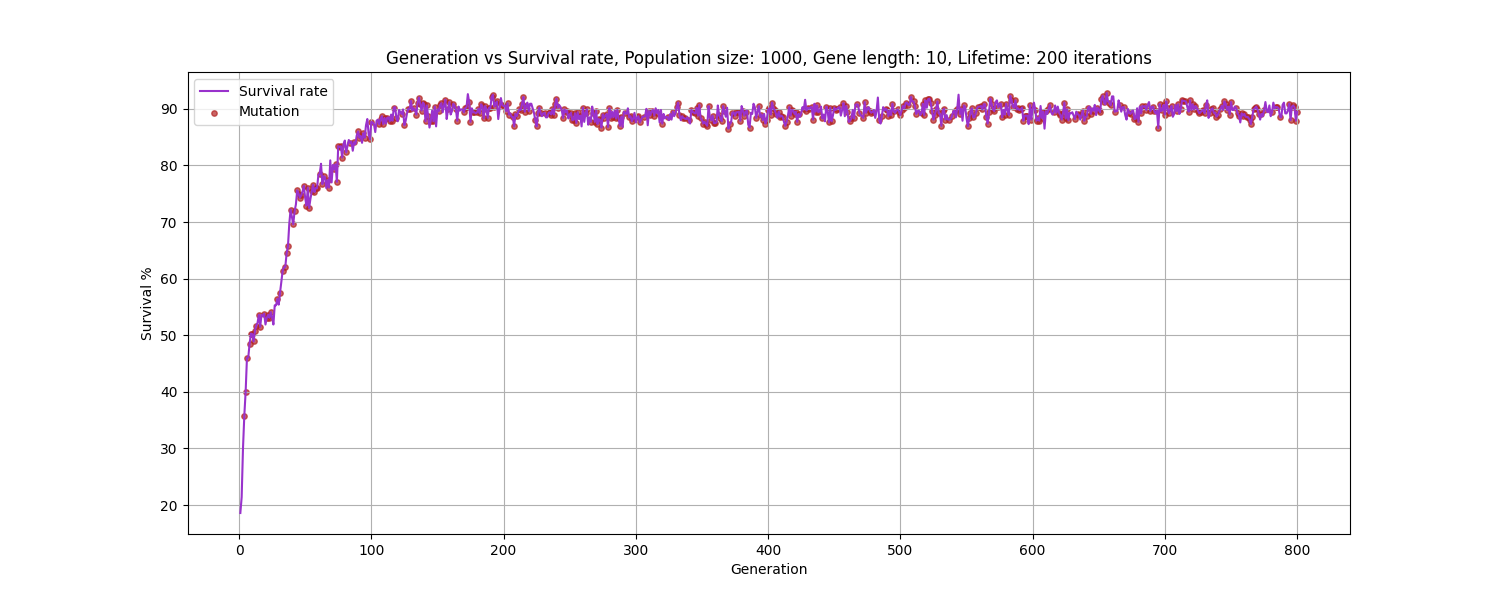

And how the standard deviation changed with every checkpoint. When the negative gradient of this curve went below a cetain value and stayed that way for a defined consecutive number of times, the program stopped executing.

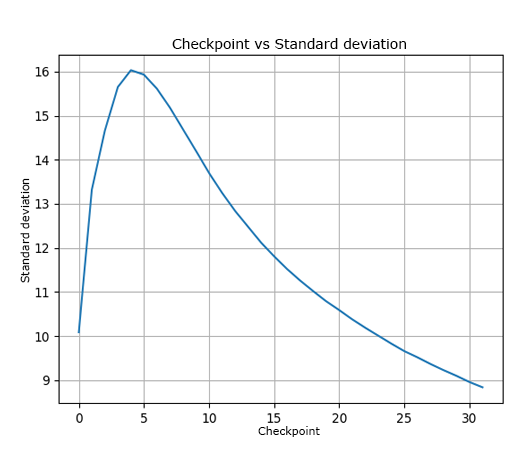

Change of survival rate for when barriers were introduced in the environment.

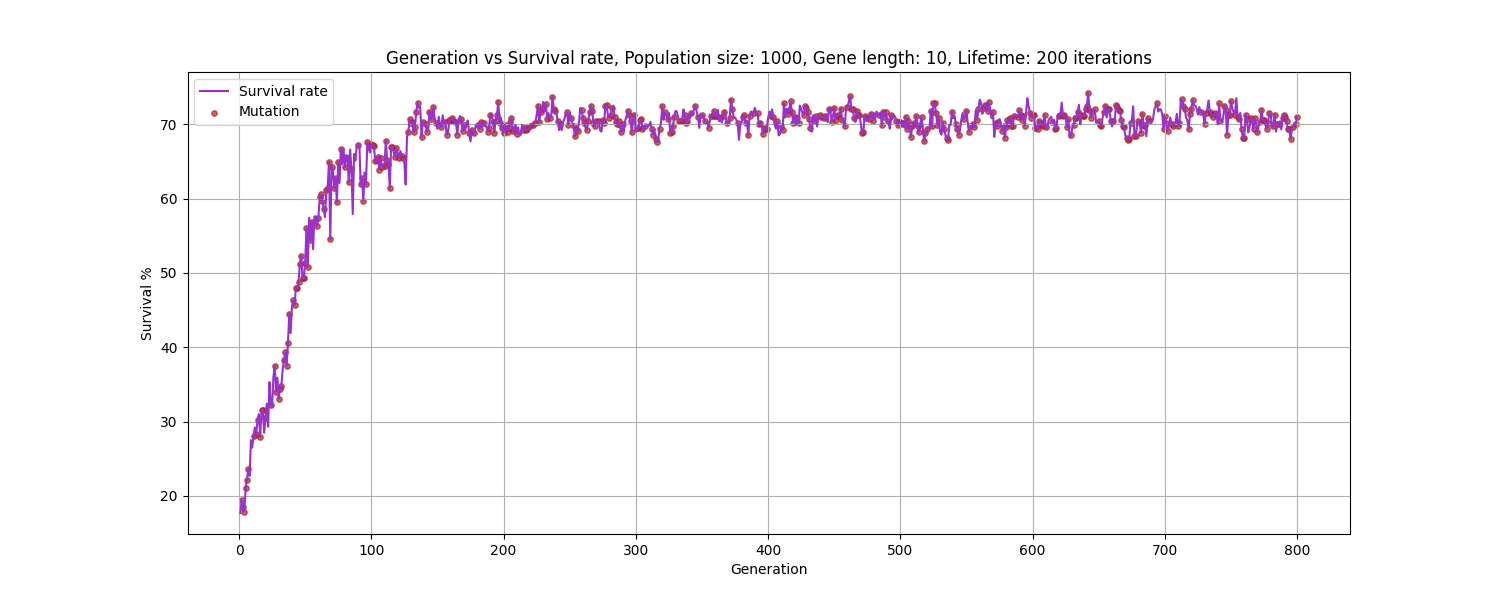

And standard deviation

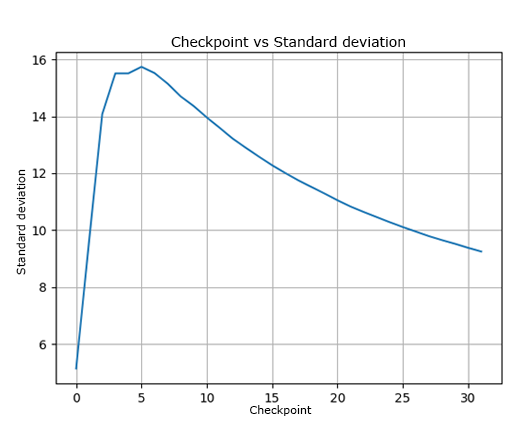

Due to mutations, there is a chance that the survival rate may still increase above these values but there is no guarantee after how many generations that successful mutation might happen and I have limited resources on my computer to speed up the process.

Improvements can be certainly made to the code to speed up certain areas by using multiprocessing, for example, as well as the multiple conditional statements that make following the code very confusing but on this occasion I was only looking to achieve the results. I tried multiprocessing to process the next state of each organism from the current state. Unfortunately, I found it taking longer than when done by iteration. I believe it is due to several I/O operations that goes into one forward pass. Furthermore, I believe with time, my conception about genetic algorithm will develop and I will realise new ways to approach these problems.

# **The End**